# 멋진 단어사전 만들기 [프로젝트]
- 1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?
- 2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?
- 3. SentencePiece의 성능을 다각도로 비교분석하였는가?

---

본 프로젝트는 한국어 형태소 분석기인 konlpy(okt, hannamum, komoran, mecab)과 sentencepice로 생성하여 토큰화한 사전과의 성능차이를 비교하고자 함

In [292]:
from konlpy.tag import Mecab
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'
with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.

max_len = 150
min_len = 10
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

In [81]:
import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy

print(tf.__version__)
print(np.__version__)
print(plt.__version__)
print(konlpy.__version__)

2.6.0
1.21.4
3.4.3
0.5.2


In [6]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [293]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_org --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_org*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_org --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_org
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 376816 Nov  7 08:47 korean_org.model
-rw-r--r-- 1 root root 146213 Nov  7 08:47 korean_org.vocab


In [147]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('이건 왜 이렇게 되는걸까')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('이건 왜 이렇게 되는걸까',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[25, 509, 3395, 4631, 1314, 3510, 2097]
['▁이', '건', '▁왜', '▁이렇게', '▁되는', '걸', '까']
이건 왜 이렇게 되는걸까


In [9]:
def sp_tokenize(s, corpus): 

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [175]:
corpus = ['이건 왜 이렇게 되는걸까']
tensor = []
for sen in corpus:
    tensor.append(s.EncodeAsIds(sen))

# print(tensor)
print(sp_tokenize(s,['이건 왜 이렇게 되는걸까'])[0][0])

print(s.SampleEncodeAsPieces('이건 왜 이렇게 되는걸까',1, 0.0))

s.SampleEncodeAsPieces('이건 왜 이렇게 되는걸까',1, 0.0)

# dogs['jindo']

sp_tokenize(s, ['corpus'])[2][509]

[  25  509 3395 4631 1314 3510 2097]
['▁이', '건', '▁왜', '▁이렇게', '▁되는', '걸', '까']


'건'

In [161]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')
sp_tokenize(s,['아버지가방에들어가신다.'])[0][0]

# SentencePiece를 활용한 sentence -> encoded pieces
# print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# print(s.DecodeIds(sp_tokenize(s,'아버지가방에들어가신다.')[0]))
# print(sp_tokenize(s,'아버지가방에들어가신다.')[0])
# sp_tokenize(s,'아버지가방에들어가신다.')[0][0:]

# tokenize('아버지가방에들어가신다.')[1]

array([1243,   11,  302,    7, 3608,   11,  287,   38,    3], dtype=int32)

# 1. 데이터 호출 및 전처리
- 네이버 영화 감성리뷰 호출
- 말뭉치 특수문자 제거
- 불용어 처리

## 1-1 데이터 호출

In [11]:
import urllib

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7fe4e6a64a00>)

In [14]:
import pandas as pd
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [16]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [17]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000


In [19]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

테스트용 리뷰 개수 : 50000


In [20]:
# document 열과 label 열의 중복을 제외한 값의 개수
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [21]:
# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

In [22]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


<AxesSubplot:>

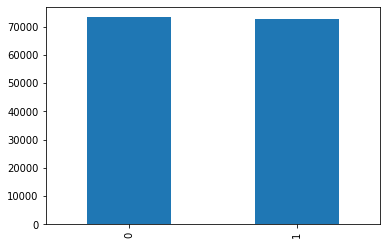

In [23]:
train_data['label'].value_counts().plot(kind = 'bar')

In [24]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [25]:
print(train_data.isnull().values.any())

True


In [26]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [27]:
# null값 확인
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [28]:
# Null값 제거
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [29]:
print(len(train_data))

146182


## 1-2 특수어 처리

In [32]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

/tmp/ipykernel_30/3525229848.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
/tmp/ipykernel_30/3525229848.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [33]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


/tmp/ipykernel_30/2260017223.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
/tmp/ipykernel_30/2260017223.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
/opt/conda/lib/python3.9/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(res

In [34]:
# 특수문자 및 공백 처리 후 null값 확인
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [35]:
# 잔여 null값 제거
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


## 1-3 불용어 처리

In [36]:
# 불용어 설정
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [135]:
train_data

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1
...,...,...,...
149995,6222902,인간이 문제지 소는 뭔죄인가,0
149996,8549745,평점이 너무 낮아서,1
149997,9311800,이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다,0
149998,2376369,청춘 영화의 최고봉방황과 우울했던 날들의 자화상,1


## 1-4 Sentence Piece 생성 및 토큰화

In [205]:
#전처리된 document를 저장
with open('naver_review.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(train_data['document']))

In [206]:
#해당파일을 호출하여 학습진행

temp_file = 'naver_review.txt'
vocab_size = 8000

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=naver_review.txt --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: naver_review.txt
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad

-rw-r--r-- 1 root root 377765 Nov  7 05:44 korean_spm.model
-rw-r--r-- 1 root root 147291 Nov  7 05:44 korean_spm.vocab


In [208]:
import csv
vocab_list = pd.read_csv('korean_spm.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)

,0,1
0,<unk>,0.00000
1,<s>,0.00000
2,</s>,0.00000
3,▁,-3.35737
4,이,-4.28745


In [212]:
len(vocab_list)

8000

In [211]:
# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds(train_data['document'][0])
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces(train_data['document'][0],1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[141, 106, 2611, 912, 4856, 4, 4856, 752, 69, 554, 514, 2648]
['▁아', '▁더', '빙', '▁진', '짜', '▁', '짜', '증', '나', '네', '요', '▁목소리']
아 더빙 진짜 짜증나네요 목소리


In [262]:
X_sp_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = s.SampleEncodeAsPieces(sentence,1, 0.0)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_sp_train.append(stopwords_removed_sentence)
    
X_sp_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = s.SampleEncodeAsPieces(sentence,1, 0.0)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_sp_test.append(stopwords_removed_sentence)
    

100%|██████████| 48852/48852 [00:01<00:00, 35834.93it/s]


In [263]:
tokenizer_sp = Tokenizer()
tokenizer_sp.fit_on_texts(X_sp_train)

In [264]:
len(tokenizer_sp.word_index)

8990

- [konlpy 태그 링크](https://konlpy.org/ko/latest/api/konlpy.tag/)
- 매개변수의 경우 okt만 원형으로 출력하는 stem옵션이 있음

# 2. Konlpy 형태소 분석기 호출 및 전처리

In [178]:
#토크나이저 호출
from konlpy.tag import Hannanum,Kkma,Komoran,Mecab,Okt
okt = Okt()
han = Hannanum()
kkma = Kkma()
komo = Komoran()
mec = Mecab()

print(okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True))
print(han.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔'))
print(kkma.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔'))
print(komo.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔'))
print(mec.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔'))
print(s.SampleEncodeAsPieces('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔',1, 0.0))

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']
['오', '아', '이런', '것', '도', '영화', '이', '라', '고', '차라리', '뮤직비디오', '를', '만들', '는', '것', '이', '나', 'ㄹ', '뻔']
['오', '아', '이렇', 'ㄴ', '것', '도', '영화', '라고', '차라리', '뮤직', '비디오', '를', '만들', '는', '것', '이', '낫', '을', '뻔']
['오', '아', '이런', '것', '도', '영화', '이', '라고', '차라리', '뮤직비디오', '를', '만들', '는', '게', '나', '을', '뻔']
['와', '이런', '것', '도', '영화', '라고', '차라리', '뮤직', '비디오', '를', '만드', '는', '게', '나을', '뻔']
['▁', '와', '▁이런', '▁것', '도', '▁영화', '라고', '▁차', '라', '리', '▁', '뮤', '직', '비', '디', '오', '를', '▁만드는', '▁게', '▁나', '을', '▁', '뻔']


In [55]:
# test데이터의 가공
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


/tmp/ipykernel_30/3570305079.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
/tmp/ipykernel_30/3570305079.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경


In [261]:
#okt 토크나이저
from tqdm import tqdm
X_okt_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_okt_train.append(stopwords_removed_sentence)

X_okt_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_okt_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [04:13<00:00, 192.44it/s]


In [265]:
#Hannanum 토크나이저
from tqdm import tqdm
X_han_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = han.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_han_train.append(stopwords_removed_sentence)

X_han_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = han.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_han_test.append(stopwords_removed_sentence)


100%|██████████| 48852/48852 [04:36<00:00, 176.53it/s]


In [186]:
#kkma 토크나이저
#중간에 메모리부족 애러..
#https://developer111.tistory.com/34
from tqdm import tqdm
X_kkma_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = kkma.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_kkma_train.append(stopwords_removed_sentence)

X_kkma_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = kkma.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_kkma_test.append(stopwords_removed_sentence)

 27%|██▋       | 39648/145393 [31:17<1:23:27, 21.12it/s] 


java.lang.OutOfMemoryError: java.lang.OutOfMemoryError: Java heap space

In [266]:
#komoran 토크나이저
from tqdm import tqdm
X_komo_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = komo.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_komo_train.append(stopwords_removed_sentence)

X_komo_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = komo.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_komo_test.append(stopwords_removed_sentence)


100%|██████████| 48852/48852 [00:56<00:00, 865.35it/s] 


In [267]:
#Mecab 토크나이저
from tqdm import tqdm
X_mec_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = mec.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_mec_train.append(stopwords_removed_sentence)

X_mec_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = mec.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_mec_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [00:04<00:00, 10277.36it/s]


In [268]:
print(X_okt_train[0])
print(X_han_train[0])
print(X_komo_train[0])
print(X_mec_train[0])

['아', '더빙', '진짜', '짜증나다', '목소리']
['아', '더빙', '진짜', '짜증나', '네', '요', '목소리']
['아', '더빙', '진짜', '짜증', '나', '네요', '목소리']
['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리']


In [270]:
import copy
X_sp_train_copy = copy.deepcopy(X_sp_train)
X_okt_train_copy = copy.deepcopy(X_okt_train)
X_han_train_copy = copy.deepcopy(X_han_train)
X_komo_train_copy = copy.deepcopy(X_komo_train)
X_mec_train_copy = copy.deepcopy(X_mec_train)

In [192]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_okt_train)

In [271]:
tokenizer_okt = Tokenizer()
tokenizer_han = Tokenizer()
tokenizer_komo = Tokenizer()
tokenizer_mec = Tokenizer()
tokenizer_okt.fit_on_texts(X_okt_train)
tokenizer_han.fit_on_texts(X_han_train)
tokenizer_komo.fit_on_texts(X_komo_train)
tokenizer_mec.fit_on_texts(X_mec_train)

In [272]:
print('sp word index : '+str(len(tokenizer_sp.word_index)))
print('okt word index : '+str(len(tokenizer_okt.word_index)))
print('hannanum word index : '+str(len(tokenizer_han.word_index)))
print('komoran word index : '+str(len(tokenizer_komo.word_index)))
print('mecab word index : '+str(len(tokenizer_mec.word_index)))

sp word index : 8990
okt word index : 43752
hannanum word index : 178333
komoran word index : 54414
mecab word index : 49946


### 본 실험에서는 Sentence peice와의 비교를 위하여 vocab_size를 8000으로 고정하고자 함


In [273]:
vocab_size = 8000 + 1 

X_sp_train = tokenizer_sp.texts_to_sequences(X_sp_train)
X_sp_test = tokenizer_sp.texts_to_sequences(X_sp_test)

X_okt_train = tokenizer_okt.texts_to_sequences(X_okt_train)
X_okt_test = tokenizer_okt.texts_to_sequences(X_okt_test)

X_han_train = tokenizer_han.texts_to_sequences(X_han_train)
X_han_test = tokenizer_han.texts_to_sequences(X_han_test)

X_komo_train = tokenizer_komo.texts_to_sequences(X_komo_train)
X_komo_test = tokenizer_komo.texts_to_sequences(X_komo_test)

X_mec_train = tokenizer_mec.texts_to_sequences(X_mec_train)
X_mec_test = tokenizer_mec.texts_to_sequences(X_mec_test)

In [274]:
X_mec_train[0]
X_sp_train[2]

[30, 106, 4944, 331, 88, 174, 20, 27, 69, 6, 325, 746, 446]

In [275]:
y_sp_train = np.array(train_data['label'])
y_okt_train = np.array(train_data['label'])
y_han_train = np.array(train_data['label'])
y_komo_train = np.array(train_data['label'])
y_mec_train = np.array(train_data['label'])

y_sp_test = np.array(test_data['label'])
y_okt_test = np.array(test_data['label'])
y_han_test = np.array(test_data['label'])
y_komo_test = np.array(test_data['label'])
y_mec_test = np.array(test_data['label'])

In [276]:
#빈 샘플 확인
drop_sp_train = [index for index, sentence in enumerate(X_sp_train) if len(sentence) < 1]
drop_okt_train = [index for index, sentence in enumerate(X_okt_train) if len(sentence) < 1]
drop_han_train = [index for index, sentence in enumerate(X_han_train) if len(sentence) < 1]
drop_komo_train = [index for index, sentence in enumerate(X_komo_train) if len(sentence) < 1]
drop_mec_train = [index for index, sentence in enumerate(X_mec_train) if len(sentence) < 1]
print(len(drop_sp_train))
print(len(drop_okt_train))
print(len(drop_han_train))
print(len(drop_komo_train))
print(len(drop_mec_train))

0
13
38
7
13


In [277]:
# 빈 샘플들을 제거
X_sp_train = np.delete(X_sp_train, drop_sp_train, axis=0)
X_okt_train = np.delete(X_okt_train, drop_okt_train, axis=0)
X_han_train = np.delete(X_han_train, drop_han_train, axis=0)
X_komo_train = np.delete(X_komo_train, drop_komo_train, axis=0)
X_mec_train = np.delete(X_mec_train, drop_mec_train, axis=0)

y_sp_train = np.delete(y_sp_train, drop_sp_train, axis=0)
y_okt_train = np.delete(y_sp_train, drop_okt_train, axis=0)
y_han_train = np.delete(y_sp_train, drop_han_train, axis=0)
y_komo_train = np.delete(y_sp_train, drop_komo_train, axis=0)
y_mec_train = np.delete(y_sp_train, drop_mec_train, axis=0)

### 문장 내 단어의 최대길이 설정
- 금번 비교는 형태소분석기의 성능 비교를 위한 실험으로 추출된 문장 길이들이 잘리지 않는 기준으로 설정
- 각 도출된 결과값의 최대 길이로 설정함

리뷰의 최대 길이 : 116
리뷰의 평균 길이 : 18.636873852248733


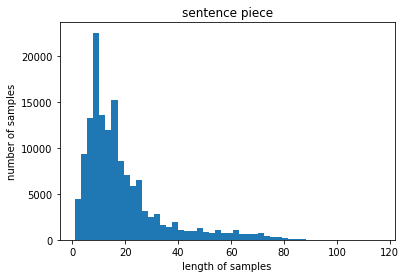

None
리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 18.638540376943183


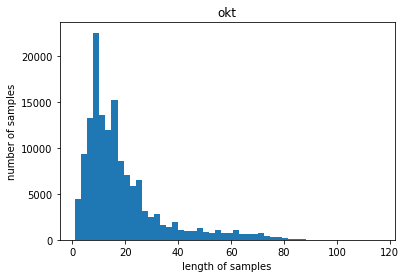

None
리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 18.641746069966633


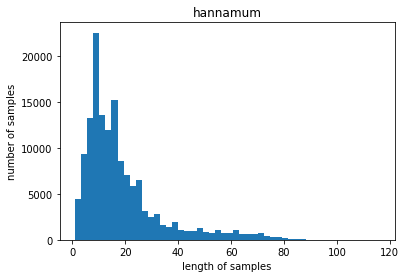

None
리뷰의 최대 길이 : 104
리뷰의 평균 길이 : 18.63777117466606


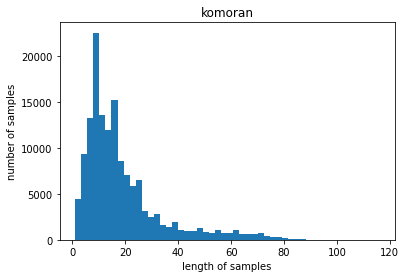

None
리뷰의 최대 길이 : 83
리뷰의 평균 길이 : 18.638540376943183


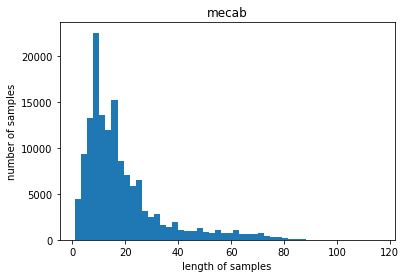

None


In [278]:
#padding
import matplotlib.pyplot as plt

def plt_data(name,data):
    print('리뷰의 최대 길이 :',max(len(review) for review in data))
    print('리뷰의 평균 길이 :',sum(map(len, X_sp_train))/len(data))
    plt.hist([len(review) for review in X_sp_train], bins=50)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.title('{0}'.format(name))
    plt.show()

print(plt_data('sentence piece',X_sp_train))
print(plt_data('okt',X_okt_train))
print(plt_data('hannamum',X_han_train))
print(plt_data('komoran',X_komo_train))
print(plt_data('mecab',X_mec_train))

In [279]:
X_sp_train = pad_sequences(X_sp_train, maxlen=116)
X_okt_train = pad_sequences(X_okt_train, maxlen=72)
X_han_train = pad_sequences(X_han_train, maxlen=72)
X_komo_train = pad_sequences(X_komo_train, maxlen=104)
X_mec_train = pad_sequences(X_mec_train, maxlen=84)


X_sp_test = pad_sequences(X_sp_test, maxlen=116)
X_okt_test = pad_sequences(X_okt_test, maxlen=72)
X_han_test = pad_sequences(X_han_test, maxlen=72)
X_komo_test = pad_sequences(X_komo_test, maxlen=104)
X_mec_test = pad_sequences(X_mec_test, maxlen=84)

리뷰의 최대 길이 : 116
리뷰의 평균 길이 : 116.0


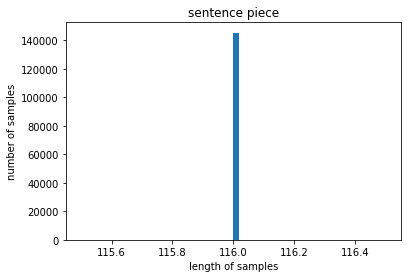

None
리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 116.01037281606824


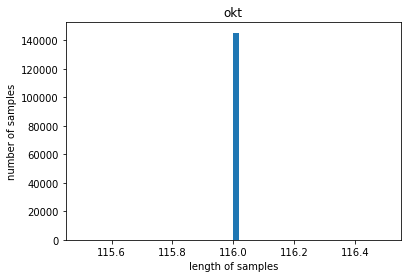

None
리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 116.03032575418803


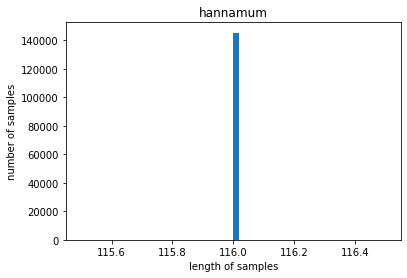

None
리뷰의 최대 길이 : 104
리뷰의 평균 길이 : 116.00558513199346


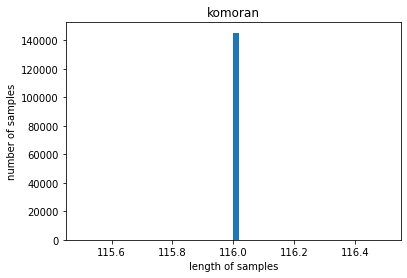

None
리뷰의 최대 길이 : 84
리뷰의 평균 길이 : 116.01037281606824


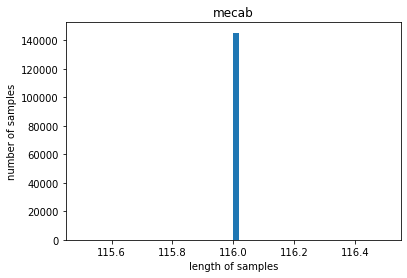

None


In [280]:
print(plt_data('sentence piece',X_sp_train))
print(plt_data('okt',X_okt_train))
print(plt_data('hannamum',X_han_train))
print(plt_data('komoran',X_komo_train))
print(plt_data('mecab',X_mec_train))

# 3. 모델 학습

In [285]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model_sp = Sequential()
model_sp.add(Embedding(vocab_size, embedding_dim))
model_sp.add(LSTM(hidden_units))
model_sp.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_sp_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model_sp.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history_sp = model_sp.fit(X_sp_train, y_sp_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1818/1818 [==============================] - 31s 12ms/step - loss: 0.4233 - acc: 0.8042 - val_loss: 0.3772 - val_acc: 0.8313

Epoch 00001: val_acc improved from -inf to 0.83132, saving model to best_sp_model.h5
Epoch 2/15
1818/1818 [==============================] - 17s 10ms/step - loss: 0.3620 - acc: 0.8384 - val_loss: 0.3654 - val_acc: 0.8369

Epoch 00002: val_acc improved from 0.83132 to 0.83686, saving model to best_sp_model.h5
Epoch 3/15
1818/1818 [==============================] - 16s 9ms/step - loss: 0.3384 - acc: 0.8513 - val_loss: 0.3509 - val_acc: 0.8428

Epoch 00003: val_acc improved from 0.83686 to 0.84277, saving model to best_sp_model.h5
Epoch 4/15
1818/1818 [==============================] - 16s 9ms/step - loss: 0.3211 - acc: 0.8603 - val_loss: 0.3604 - val_acc: 0.8420

Epoch 00004: val_acc did not improve from 0.84277
Epoch 5/15
1818/1818 [==============================] - 16s 9ms/step - loss: 0.3068 - acc: 0.8681 - val_loss: 0.3409 - val_acc: 0.8498

Epoch 0

In [286]:
embedding_dim = 100
hidden_units = 128

model_okt = Sequential()
model_okt.add(Embedding(vocab_size, embedding_dim))
model_okt.add(LSTM(hidden_units))
model_okt.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_okt_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model_okt.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history_okt = model_okt.fit(X_okt_train, y_okt_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1818/1818 [==============================] - 15s 7ms/step - loss: 0.3940 - acc: 0.8225 - val_loss: 0.3647 - val_acc: 0.8392

Epoch 00001: val_acc improved from -inf to 0.83918, saving model to best_okt_model.h5
Epoch 2/15
1818/1818 [==============================] - 13s 7ms/step - loss: 0.3329 - acc: 0.8543 - val_loss: 0.3396 - val_acc: 0.8519

Epoch 00002: val_acc improved from 0.83918 to 0.85194, saving model to best_okt_model.h5
Epoch 3/15
1818/1818 [==============================] - 13s 7ms/step - loss: 0.3117 - acc: 0.8656 - val_loss: 0.3284 - val_acc: 0.8569

Epoch 00003: val_acc improved from 0.85194 to 0.85689, saving model to best_okt_model.h5
Epoch 4/15
1818/1818 [==============================] - 13s 7ms/step - loss: 0.2978 - acc: 0.8724 - val_loss: 0.3254 - val_acc: 0.8578

Epoch 00004: val_acc improved from 0.85689 to 0.85775, saving model to best_okt_model.h5
Epoch 5/15
1818/1818 [==============================] - 13s 7ms/step - loss: 0.2859 - acc: 0.8791 - val

In [287]:
embedding_dim = 100
hidden_units = 128

model_han = Sequential()
model_han.add(Embedding(vocab_size, embedding_dim))
model_han.add(LSTM(hidden_units))
model_han.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_han_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model_han.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history_han = model_han.fit(X_han_train, y_han_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1817/1817 [==============================] - 15s 7ms/step - loss: 0.4577 - acc: 0.7750 - val_loss: 0.4240 - val_acc: 0.7965

Epoch 00001: val_acc improved from -inf to 0.79653, saving model to best_han_model.h5
Epoch 2/15
1817/1817 [==============================] - 13s 7ms/step - loss: 0.3975 - acc: 0.8125 - val_loss: 0.4009 - val_acc: 0.8075

Epoch 00002: val_acc improved from 0.79653 to 0.80751, saving model to best_han_model.h5
Epoch 3/15
1817/1817 [==============================] - 13s 7ms/step - loss: 0.3765 - acc: 0.8245 - val_loss: 0.3919 - val_acc: 0.8146

Epoch 00003: val_acc improved from 0.80751 to 0.81463, saving model to best_han_model.h5
Epoch 4/15
1817/1817 [==============================] - 13s 7ms/step - loss: 0.3626 - acc: 0.8312 - val_loss: 0.3876 - val_acc: 0.8161

Epoch 00004: val_acc improved from 0.81463 to 0.81607, saving model to best_han_model.h5
Epoch 5/15
1817/1817 [==============================] - 13s 7ms/step - loss: 0.3512 - acc: 0.8378 - val

In [288]:
embedding_dim = 100
hidden_units = 128

model_komo = Sequential()
model_komo.add(Embedding(vocab_size, embedding_dim))
model_komo.add(LSTM(hidden_units))
model_komo.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_komo_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model_komo.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history_komo = model_komo.fit(X_komo_train, y_komo_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1818/1818 [==============================] - 19s 10ms/step - loss: 0.4082 - acc: 0.8119 - val_loss: 0.3919 - val_acc: 0.8209

Epoch 00001: val_acc improved from -inf to 0.82093, saving model to best_komo_model.h5
Epoch 2/15
1818/1818 [==============================] - 15s 8ms/step - loss: 0.3463 - acc: 0.8463 - val_loss: 0.3448 - val_acc: 0.8472

Epoch 00002: val_acc improved from 0.82093 to 0.84717, saving model to best_komo_model.h5
Epoch 3/15
1818/1818 [==============================] - 15s 8ms/step - loss: 0.3227 - acc: 0.8582 - val_loss: 0.3442 - val_acc: 0.8460

Epoch 00003: val_acc did not improve from 0.84717
Epoch 4/15
1818/1818 [==============================] - 15s 8ms/step - loss: 0.3061 - acc: 0.8679 - val_loss: 0.3300 - val_acc: 0.8527

Epoch 00004: val_acc improved from 0.84717 to 0.85267, saving model to best_komo_model.h5
Epoch 5/15
1818/1818 [==============================] - 15s 8ms/step - loss: 0.2928 - acc: 0.8749 - val_loss: 0.3333 - val_acc: 0.8559

Ep

In [289]:
embedding_dim = 100
hidden_units = 128

model_mec = Sequential()
model_mec.add(Embedding(vocab_size, embedding_dim))
model_mec.add(LSTM(hidden_units))
model_mec.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_mec_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model_mec.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history_mec = model_mec.fit(X_mec_train, y_mec_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1818/1818 [==============================] - 18s 9ms/step - loss: 0.3934 - acc: 0.8215 - val_loss: 0.3648 - val_acc: 0.8433

Epoch 00001: val_acc improved from -inf to 0.84327, saving model to best_mec_model.h5
Epoch 2/15
1818/1818 [==============================] - 14s 8ms/step - loss: 0.3280 - acc: 0.8563 - val_loss: 0.3256 - val_acc: 0.8578

Epoch 00002: val_acc improved from 0.84327 to 0.85779, saving model to best_mec_model.h5
Epoch 3/15
1818/1818 [==============================] - 14s 8ms/step - loss: 0.3044 - acc: 0.8692 - val_loss: 0.3175 - val_acc: 0.8616

Epoch 00003: val_acc improved from 0.85779 to 0.86157, saving model to best_mec_model.h5
Epoch 4/15
1818/1818 [==============================] - 14s 8ms/step - loss: 0.2876 - acc: 0.8776 - val_loss: 0.3160 - val_acc: 0.8647

Epoch 00004: val_acc improved from 0.86157 to 0.86473, saving model to best_mec_model.h5
Epoch 5/15
1818/1818 [==============================] - 14s 8ms/step - loss: 0.2753 - acc: 0.8844 - val

# 4. 결과 확인 및 회고
- 성능자체는 mecab의 성능이 가장 높게 나온것을 확인했다.
- 토큰화 과정간의 처리 속도는 sentence piece(4sec) >  mecab(14sec) > komoran(2m 41sec) > okt(11m 58sec)> hannamum(13m 16sec) > kkoma(메모리 에러로 인한 학습불가) 순으로 차이가 있음
- 각각의 토큰화 방법에 따라 결과값이 다르게 평가되는 것을 확인하였지만 sentence piece의 장점을 확인하긴 어려웠음.
- 추가 진행으로 vocab size를 변경하여 추가 학습을 진행하고자 함

In [290]:
loaded_sp_model = load_model('best_sp_model.h5')
loaded_okt_model = load_model('best_okt_model.h5')
loaded_han_model = load_model('best_han_model.h5')
loaded_komo_model = load_model('best_komo_model.h5')
loaded_mec_model = load_model('best_mec_model.h5')

print("\n sp 테스트 정확도: %.4f" % (loaded_sp_model.evaluate(X_sp_test, y_sp_test)[1]))
print("\n okt 테스트 정확도: %.4f" % (loaded_okt_model.evaluate(X_okt_test, y_okt_test)[1]))
print("\n han 테스트 정확도: %.4f" % (loaded_han_model.evaluate(X_han_test, y_han_test)[1]))
print("\n komo 테스트 정확도: %.4f" % (loaded_komo_model.evaluate(X_komo_test, y_komo_test)[1]))
print("\n mec 테스트 정확도: %.4f" % (loaded_mec_model.evaluate(X_mec_test, y_mec_test)[1]))

1527/1527 [==============================] - 6s 4ms/step - loss: 0.3444 - acc: 0.8487

 sp 테스트 정확도: 0.8487
1527/1527 [==============================] - 5s 3ms/step - loss: 0.3413 - acc: 0.8560

 okt 테스트 정확도: 0.8560
1527/1527 [==============================] - 5s 3ms/step - loss: 0.3914 - acc: 0.8167

 han 테스트 정확도: 0.8167
1527/1527 [==============================] - 5s 3ms/step - loss: 0.3370 - acc: 0.8535

 komo 테스트 정확도: 0.8535
1527/1527 [==============================] - 5s 3ms/step - loss: 0.3212 - acc: 0.8625

 mec 테스트 정확도: 0.8625


## 네이버 데이터가 아닌 다른 데이터로 사전구축했을 경우

In [295]:
# sentencepeice 사전구축을 달리할 경우
ss = spm.SentencePieceProcessor()
ss.Load('korean_org.model')


True

In [297]:
X_sp_org_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = ss.SampleEncodeAsPieces(sentence,1, 0.0)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_sp_org_train.append(stopwords_removed_sentence)
    
X_sp_org_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = ss.SampleEncodeAsPieces(sentence,1, 0.0)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_sp_org_test.append(stopwords_removed_sentence)

tokenizer_org_sp = Tokenizer()
tokenizer_org_sp.fit_on_texts(X_sp_org_train)

100%|██████████| 48852/48852 [00:01<00:00, 35049.56it/s]


리뷰의 최대 길이 : 116
리뷰의 평균 길이 : 116.0


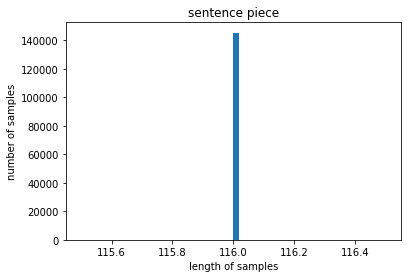

None


In [299]:
X_sp_org_train = tokenizer_sp.texts_to_sequences(X_sp_org_train)
X_sp_org_test = tokenizer_sp.texts_to_sequences(X_sp_org_test)
y_sp_org_train = np.array(train_data['label'])
y_sp_org_test = np.array(test_data['label'])
drop_sp_org_train = [index for index, sentence in enumerate(X_sp_train) if len(sentence) < 1]
X_sp_org_train = np.delete(X_sp_train, drop_sp_train, axis=0)
y_sp_org_train = np.delete(y_sp_train, drop_sp_train, axis=0)
print(plt_data('sentence piece',X_sp_org_train))


In [302]:
# print(plt_data('sentence piece',X_sp_train))
X_sp_org_train = pad_sequences(X_sp_train, maxlen=116)
X_sp_org_test = pad_sequences(X_sp_test, maxlen=116)

model_org_sp = Sequential()
model_org_sp.add(Embedding(vocab_size, embedding_dim))
model_org_sp.add(LSTM(hidden_units))
model_org_sp.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_sp_org_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model_org_sp.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history_org_sp = model_sp.fit(X_sp_org_train, y_sp_org_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1818/1818 [==============================] - 18s 10ms/step - loss: 0.2348 - acc: 0.9056 - val_loss: 0.3693 - val_acc: 0.8487

Epoch 00001: val_acc improved from -inf to 0.84869, saving model to best_sp_org_model.h5
Epoch 2/15
1818/1818 [==============================] - 16s 9ms/step - loss: 0.2178 - acc: 0.9132 - val_loss: 0.3727 - val_acc: 0.8426

Epoch 00002: val_acc did not improve from 0.84869
Epoch 3/15
1818/1818 [==============================] - 16s 9ms/step - loss: 0.2009 - acc: 0.9203 - val_loss: 0.3924 - val_acc: 0.8444

Epoch 00003: val_acc did not improve from 0.84869
Epoch 4/15
1818/1818 [==============================] - 16s 9ms/step - loss: 0.1828 - acc: 0.9285 - val_loss: 0.4081 - val_acc: 0.8419

Epoch 00004: val_acc did not improve from 0.84869
Epoch 5/15
1818/1818 [==============================] - 16s 9ms/step - loss: 0.1648 - acc: 0.9370 - val_loss: 0.4583 - val_acc: 0.8338

Epoch 00005: val_acc did not improve from 0.84869
Epoch 00005: early stopping


In [303]:
loaded_sp_org_model = load_model('best_sp_org_model.h5')
print("\n sp 테스트 정확도: %.4f" % (loaded_sp_org_model.evaluate(X_sp_org_test, y_sp_org_test)[1]))

# sp 테스트 정확도: 0.8487
# sp_org 테스트 정확도 : 0.8458
# 다른 데이터로 sentence piece를 진행한 결과가 근소하게 떨어지는 것을 확인

1527/1527 [==============================] - 6s 4ms/step - loss: 0.3728 - acc: 0.8458

 sp 테스트 정확도: 0.8458
